In [1]:
%load_ext rich

# Spapros Selection: Create a probeset with spapros

This tutorial shows how to select a gene probeset with spapros.

The used dataset contains 3k PBMCs from a healthy donor and is publicly available from
[10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)
[here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).
It is also available via scanpy [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html#scanpy.datasets.pbmc3k).

You can also derive it from scanpy [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html#scanpy.datasets.pbmc3k), like we will do in this tutorial.

The preprocessed Anndata consists of log-normalized single cell RNAseq counts of 2638 cells for 13714 genes.

## Import packages and setup

To run the notebook locally, create a conda environment using this [environment.yaml](TODO link):

    conda create -f environment.yaml

Then add the conda environment as ipython kernel:

    python -m ipykernel install --user --name spapros --display-name Python (spapros)



In [2]:
import spapros
from spapros import se, pl
import scanpy as sc

In [3]:
sc.settings.verbosity = 1
sc.logging.print_header()
print(f"spapros=={spapros.__version__}")

scanpy==1.8.1 anndata==0.7.8 umap==0.5.2 numpy==1.21.4 scipy==1.7.2 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 pynndescent==0.5.5
spapros==0.1.0


## Preprocess data

The spapros pipeline reaches the best results, if the data is logarithmized and normalized. 
We are using these preprocessing steps from the [scanpy pipeline](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) but only save the highly variable genes and the size factors to keep the adata clean. 

In [4]:
# Load the dataset
adata = sc.read_h5ad("../data/small_data_raw_counts.h5ad")
# Load the dataset
adata = sc.datasets.pbmc3k()

# Do preprocessing on a copy 
adata_pp = adata.copy()

# Basic filtering
sc.pp.filter_cells(adata_pp, min_genes=200)
sc.pp.filter_genes(adata_pp, min_cells=3)
adata_pp.var['mt'] = adata_pp.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_pp, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[((adata_pp.obs.n_genes_by_counts < 2500) & (adata_pp.obs.pct_counts_mt < 5)), :]

# Calculate size factors
sc.pp.normalize_total(adata_pp, target_sum=1e4, key_added="size_factors")

# Logarithmize copy
sc.pp.log1p(adata_pp)

# Find highly variable genes
sc.pp.highly_variable_genes(adata_pp, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Cluster celltypes
sc.tl.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="celltype")

# Actually filter read adata
adata = adata[:, adata.var["gene_ids"].isin(adata_pp.var["gene_ids"])]

# Logarithmize
sc.pp.log1p(adata)

# Save highly variable genes
adata.var["highly_variable"] = adata_pp.var["highly_variable"]

# Save size factors
adata.obs["size_factors"] = adata_pp.obs["size_factors"]

# Annotate cell types: 
adata.obs["celltype"] = adata_pp.obs["celltype"]

adata

/home/st/strasserl/anaconda3/envs/spapros/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'size_factors', 'celltype'
    var: 'gene_ids', 'highly_variable'
    uns: 'log1p'

## Start the selection

TODO short description of spapros selection pipeline with figure

In [5]:
# create an instance of the ProbesetSelector class
selector = se.ProbesetSelector(adata, n=50, celltype_key = "celltype", verbosity=1)

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 7 : 12
	 8 : 4


In [6]:
# invoke the central method
selector.select_probeset()


Output()

Select pca genes...
Select genes based on differential expression and forests as baseline for the final forests...


Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Add DE genes with specific reference groups to improve tree performance...


Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Train final forests by adding genes from the DE_baseline forest for celltypes with low performance...


Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

Adding genes from reference tree...
Train final trees on all celltypes, now with the added genes...


Train hierarchical trees:   0%|          | 0/3 [00:00<?, ?it/s]

	 Finished...


The selected probeset can be examined like this: 

In [7]:
selected_probeset = selector.probeset
selected_probeset

,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
PPBP,1,True,1.0,1.0,1.0,1.000000,0.685560,False,False,True,8,,8,8,False,True,False
CCL5,2,True,1.0,1.0,1.0,0.809536,2.263984,False,False,True,4,,4,4,False,True,False
GNLY,3,True,1.0,1.0,1.0,0.796300,1.766372,False,False,True,6,,6,6,False,True,False
S100A8,4,True,1.0,1.0,1.0,0.727463,2.103447,False,False,True,1,,1,1,False,True,False
S100A11,5,True,1.0,1.0,1.0,0.613046,1.362735,False,False,True,,2,2,2,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF594,1868,False,NaN,NaN,NaN,NaN,0.009355,False,False,False,,,,,False,False,False
C1orf186,1869,False,NaN,NaN,NaN,NaN,0.008783,False,False,False,,,,,False,False,False
RP11-496I9.1,1870,False,NaN,NaN,NaN,NaN,0.008131,False,False,False,,,,,False,False,False
FRMPD3,1871,False,NaN,NaN,NaN,NaN,0.007948,False,False,False,,,,,False,False,False


In [8]:
# list of the selected genes: 
selected_probeset.index[selected_probeset.selection]

Index(['PPBP', 'CCL5', 'GNLY', 'S100A8', 'S100A11', 'LST1', 'CD79A', 'LTB',
       'HLA-DQA1', 'GPX1', 'HLA-DQB1', 'IL32', 'FCER1G', 'NKG7', 'CD79B',
       'FCGR3A', 'GSTP1', 'HLA-DRB1', 'TYROBP', 'CD2', 'HLA-DMA', 'ATP6V0E1',
       'APOBEC3A', 'VAMP8', 'PSMB8', 'GZMB', 'COTL1', 'PPIB', 'UBB', 'AIF1',
       'ARPC1B', 'FCN1', 'LGALS2', 'SRGN', 'PSMA7', 'MS4A1', 'MT-ND5', 'CST7',
       'GIMAP5', 'GZMA', 'TCL1A', 'LYAR', 'PTPRCAP', 'CTSW', 'CD37',
       'HLA-DPA1', 'SDPR', 'HLA-DPB1', 'YWHAB', 'DYNLL1'],
      dtype='object')

## Vizualize the results

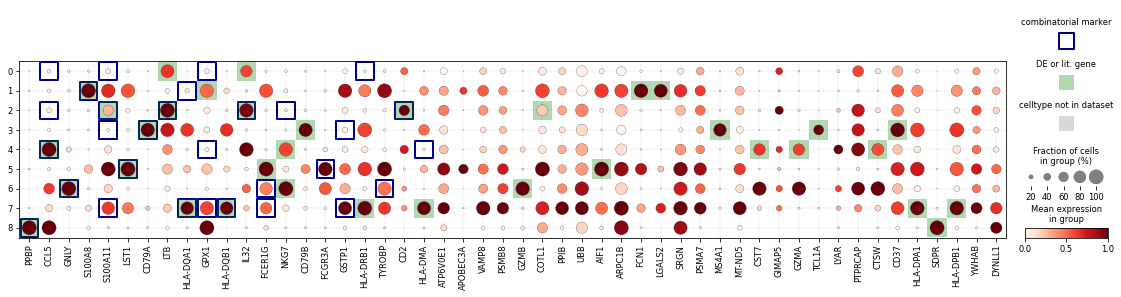

In [9]:
pl.masked_dotplot(adata, selector)

## What's next?

Now you should evaluate the selected probeset. See our [basic evaluation tutoral](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_basic_evaluation.html).

If you want to customize and improve the probeset selection, have a look at the [advanced selection tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_advanced_selection.html).